# NFL 1st and Future: Injury Record – Modeling `BodyPart`

In [2]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load and clean data
df = pd.read_csv("InjuryRecord.csv")
df = df[df['BodyPart'] != 'Heel']  # Remove class with only 1 instance

# Feature/target split
X = df.drop(columns=['BodyPart', 'PlayerKey', 'GameID', 'PlayKey'])
y = df['BodyPart']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Preprocessor: one-hot encode 'Surface', passthrough other columns
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), ['Surface'])
], remainder='passthrough')


## Week 1 – Polynomial and Interaction Terms

In [15]:

poly_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    ('model', OneVsRestClassifier(LogisticRegression(max_iter=1000)))
])

poly_pipeline.fit(X_train, y_train)
poly_preds = poly_pipeline.predict(X_test)
print("Week 1 - Polynomial Accuracy:", accuracy_score(y_test, poly_preds))
print(classification_report(y_test, poly_preds,zero_division=0))


Week 1 - Polynomial Accuracy: 0.34615384615384615
              precision    recall  f1-score   support

       Ankle       0.36      0.50      0.42        10
        Foot       0.00      0.00      0.00         2
        Knee       0.33      0.33      0.33        12
        Toes       0.00      0.00      0.00         2

    accuracy                           0.35        26
   macro avg       0.17      0.21      0.19        26
weighted avg       0.29      0.35      0.31        26



## Week 2 – Ridge Classifier

In [14]:

ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RidgeClassifierCV(alphas=[0.01, 0.1, 1.0, 10.0]))
])

ridge_pipeline.fit(X_train, y_train)
ridge_preds = ridge_pipeline.predict(X_test)
print("Week 2 - Ridge Accuracy:", accuracy_score(y_test, ridge_preds))
print(classification_report(y_test, ridge_preds, zero_division=0))


Week 2 - Ridge Accuracy: 0.34615384615384615
              precision    recall  f1-score   support

       Ankle       0.36      0.50      0.42        10
        Foot       0.00      0.00      0.00         2
        Knee       0.33      0.33      0.33        12
        Toes       0.00      0.00      0.00         2

    accuracy                           0.35        26
   macro avg       0.17      0.21      0.19        26
weighted avg       0.29      0.35      0.31        26



In [13]:
# Get the trained RidgeClassifierCV model from the pipeline
ridge_model = ridge_pipeline.named_steps['model']

# Get the feature names after preprocessing (OneHot + passthrough)
feature_names = ridge_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Create a Series of coefficients
ridge_coef = pd.Series(ridge_model.coef_[0], index=feature_names)

# Sort and display top 10 influential features
ridge_coef.sort_values(ascending=False).head(10)


cat__Surface_Synthetic    0.156109
remainder__DM_M42         0.154577
remainder__DM_M1          0.000000
remainder__DM_M28        -0.106509
remainder__DM_M7         -0.301759
dtype: float64

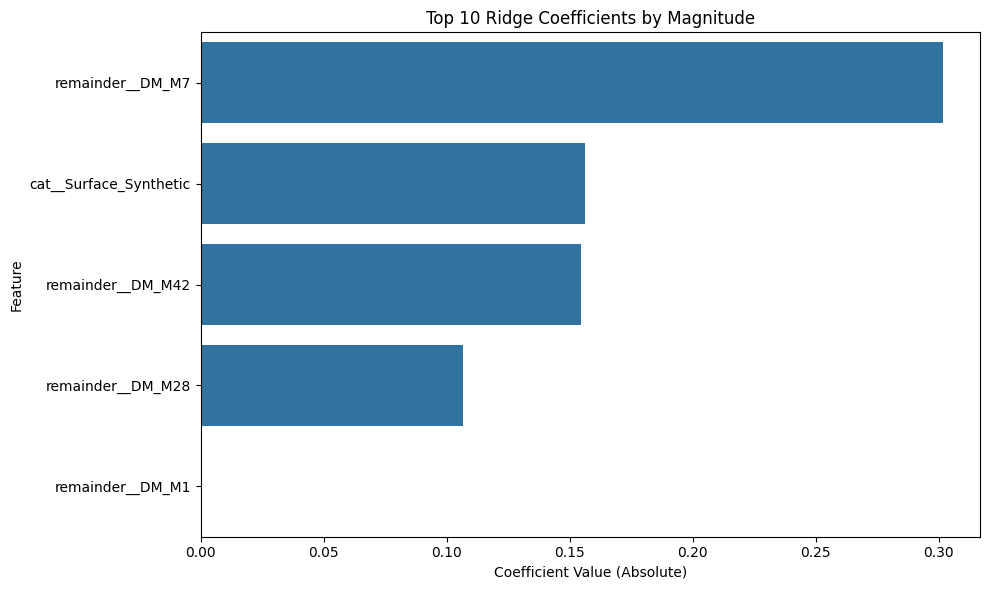

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get model from pipeline
ridge_model = ridge_pipeline.named_steps['model']
# Get feature names after preprocessing
feature_names = ridge_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Create coefficient series
coef_series = pd.Series(ridge_model.coef_[0], index=feature_names)
top_features = coef_series.abs().sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Top 10 Ridge Coefficients by Magnitude")
plt.xlabel("Coefficient Value (Absolute)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


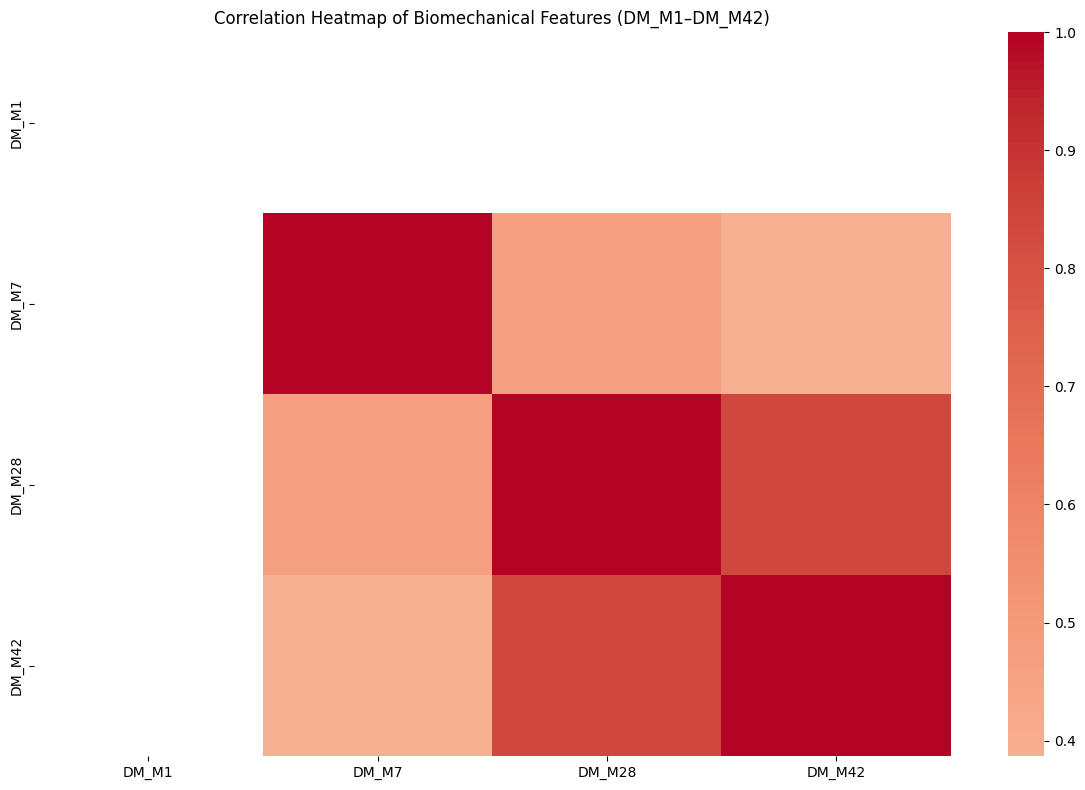

In [19]:
# Assuming df is the raw dataframe and includes DM_M1–DM_M42
dm_features = [col for col in df.columns if 'DM_M' in col]
corr = df[dm_features].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap of Biomechanical Features (DM_M1–DM_M42)")
plt.tight_layout()
plt.show()


## Week 3 – Feature Selection (PCR, PLS, Stepwise Approximation)

In [17]:

from sklearn.decomposition import TruncatedSVD
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import make_pipeline

# Prepare one-hot encoded matrix
X_encoded = preprocessor.fit_transform(X)
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(X_encoded, y, stratify=y, random_state=42)

# PCR approximation using TruncatedSVD
pcr = make_pipeline(TruncatedSVD(n_components=2), LogisticRegression(max_iter=1000))
pcr.fit(X_train_enc, y_train_enc)
print("PCR Accuracy:", accuracy_score(y_test_enc, pcr.predict(X_test_enc)))

# PLSR
pls = PLSRegression(n_components=2)
pls.fit(X_train_enc, pd.get_dummies(y_train_enc))
pls_preds = pls.predict(X_test_enc).argmax(axis=1)
y_pred_labels = pd.get_dummies(y_train_enc).columns[pls_preds]
print("PLSR Predicted Labels:", list(y_pred_labels))

# Stepwise approximation with LogisticRegressionCV
stepwise = LogisticRegressionCV(cv=5, max_iter=1000).fit(X_train_enc, y_train_enc)
stepwise_preds = stepwise.predict(X_test_enc)
print("Stepwise Accuracy:", accuracy_score(y_test_enc, stepwise_preds))
print(classification_report(y_test_enc, stepwise_preds))


PCR Accuracy: 0.46153846153846156
PLSR Predicted Labels: ['Ankle', 'Knee', 'Ankle', 'Knee', 'Knee', 'Ankle', 'Knee', 'Knee', 'Knee', 'Knee', 'Ankle', 'Ankle', 'Ankle', 'Ankle', 'Ankle', 'Knee', 'Knee', 'Ankle', 'Ankle', 'Ankle', 'Ankle', 'Knee', 'Knee', 'Ankle', 'Ankle', 'Knee']
Stepwise Accuracy: 0.4230769230769231
              precision    recall  f1-score   support

       Ankle       0.25      0.10      0.14        10
        Foot       0.00      0.00      0.00         2
        Knee       0.45      0.83      0.59        12
        Toes       0.00      0.00      0.00         2

    accuracy                           0.42        26
   macro avg       0.18      0.23      0.18        26
weighted avg       0.31      0.42      0.33        26



/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Week 4 – Logistic Regression

In [6]:

logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000))
])
logreg_pipeline.fit(X_train, y_train)
logreg_preds = logreg_pipeline.predict(X_test)
print("Week 4 - Logistic Accuracy:", accuracy_score(y_test, logreg_preds))
print(classification_report(y_test, logreg_preds))


Week 4 - Logistic Accuracy: 0.34615384615384615
              precision    recall  f1-score   support

       Ankle       0.36      0.50      0.42        10
        Foot       0.00      0.00      0.00         2
        Knee       0.33      0.33      0.33        12
        Toes       0.00      0.00      0.00         2

    accuracy                           0.35        26
   macro avg       0.17      0.21      0.19        26
weighted avg       0.29      0.35      0.31        26



/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Week 5 – SVM (Linear)

In [7]:

svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', SVC(kernel='linear'))
])
svm_pipeline.fit(X_train, y_train)
svm_preds = svm_pipeline.predict(X_test)
print("Week 5 - SVM Accuracy:", accuracy_score(y_test, svm_preds))
print(classification_report(y_test, svm_preds))


Week 5 - SVM Accuracy: 0.46153846153846156
              precision    recall  f1-score   support

       Ankle       0.44      0.40      0.42        10
        Foot       0.00      0.00      0.00         2
        Knee       0.47      0.67      0.55        12
        Toes       0.00      0.00      0.00         2

    accuracy                           0.46        26
   macro avg       0.23      0.27      0.24        26
weighted avg       0.39      0.46      0.42        26



/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Week 6 – Decision Tree and Random Forest

In [8]:

tree_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', DecisionTreeClassifier(max_depth=3, random_state=42))
])
tree_pipeline.fit(X_train, y_train)
tree_preds = tree_pipeline.predict(X_test)
print("Week 6 - Tree Accuracy:", accuracy_score(y_test, tree_preds))

forest_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42))
])
forest_pipeline.fit(X_train, y_train)
forest_preds = forest_pipeline.predict(X_test)
print("Week 6 - Random Forest Accuracy:", accuracy_score(y_test, forest_preds))
print(classification_report(y_test, forest_preds))


Week 6 - Tree Accuracy: 0.34615384615384615
Week 6 - Random Forest Accuracy: 0.34615384615384615
              precision    recall  f1-score   support

       Ankle       0.36      0.50      0.42        10
        Foot       0.00      0.00      0.00         2
        Knee       0.33      0.33      0.33        12
        Toes       0.00      0.00      0.00         2

    accuracy                           0.35        26
   macro avg       0.17      0.21      0.19        26
weighted avg       0.29      0.35      0.31        26



/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [11]:
from sklearn.metrics import classification_report

print("Ridge Classifier Report:")
print(classification_report(y_test, ridge_pipeline.predict(X_test)))

print("Random Forest Report:")
print(classification_report(y_test, forest_pipeline.predict(X_test)))


Ridge Classifier Report:
              precision    recall  f1-score   support

       Ankle       0.36      0.50      0.42        10
        Foot       0.00      0.00      0.00         2
        Knee       0.33      0.33      0.33        12
        Toes       0.00      0.00      0.00         2

    accuracy                           0.35        26
   macro avg       0.17      0.21      0.19        26
weighted avg       0.29      0.35      0.31        26

Random Forest Report:
              precision    recall  f1-score   support

       Ankle       0.36      0.50      0.42        10
        Foot       0.00      0.00      0.00         2
        Knee       0.33      0.33      0.33        12
        Toes       0.00      0.00      0.00         2

    accuracy                           0.35        26
   macro avg       0.17      0.21      0.19        26
weighted avg       0.29      0.35      0.31        26



/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespa

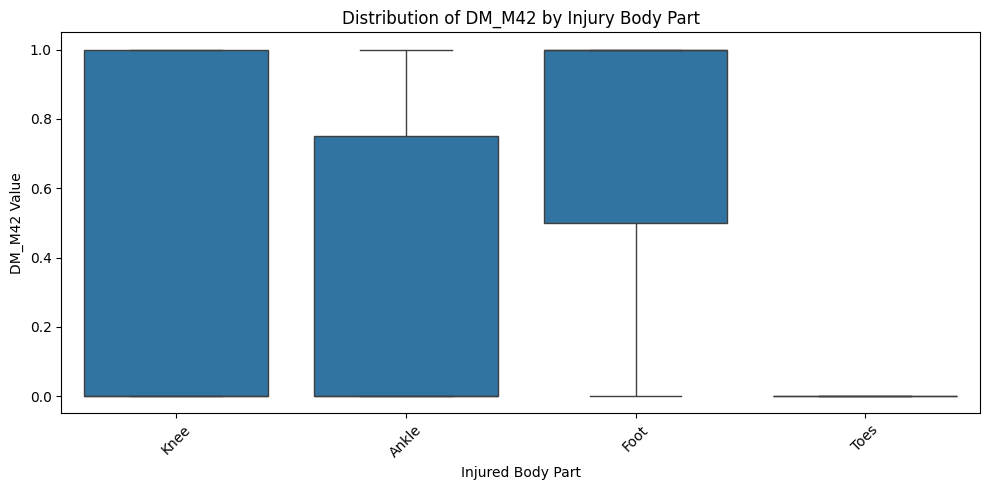

In [20]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='BodyPart', y='DM_M42')
plt.title('Distribution of DM_M42 by Injury Body Part')
plt.xlabel('Injured Body Part')
plt.ylabel('DM_M42 Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
